# Model Training Notebook

This notebook trains a computer vision model using PyTorch.  
It loads the dataset, initializes the model, trains it, visualizes metrics,  
and evaluates it on a validation set.

The workflow:
1. Import libraries
2. Set hyperparameters
3. Load dataset  
4. Initialize model  
5. Train  
6. Visualize metrics and confusion matrix  
7. Save hyperparameters

## Step 1 – Import libraries
We start by importing all required packages and modules for training and evaluation.

In [1]:
import torch
from torch import optim
from torch.optim.lr_scheduler import StepLR
import time

from models.resnet import ResNetModel
from models.wide_resnet import WideResNetModel
from models.vit import ViTModel
from models.convnext import ConvNeXtModel
from data_loader import get_torchvision_dataset
from core.visualizer import Visualizer
from core.metrics import (topk_accuracy_torch, f1_score_torch,
                          precision_score_torch, recall_score_torch,
                          confusion_matrix_torch, plot_confusion_matrix)

## Step 2 – Set hyperparameters
Here we define all training parameters such as learning rate, optimizer, scheduler, number of epochs, etc.  
You can modify them freely to experiment with different settings.

In [2]:
# Model hyperparameters
optimizer = optim.Adam
optimizer_params = {"weight_decay": 5e-4}
scheduler = StepLR
scheduler_params = {"step_size": 10, "gamma": 0.1}
learning_rate = 0.001
num_epochs = 5
label_smoothing = 0

# Dataset parameters
num_classes = 10
batch_size = 128
dataset_name = 'Cifar10'
image_size = (32,32)
resume = False  # True to load a checkpoint if it exists
# Change run_id if you want to resume a training
run_id = 'last_run_id' if resume else None

metrics = {
    "Top-1 Accuracy": (topk_accuracy_torch, {"k": 1}),
    "F1": (f1_score_torch, {"num_classes": num_classes}),
    "Precision": (precision_score_torch, {"num_classes": num_classes}),
    "Recall": (recall_score_torch, {"num_classes": num_classes}),
}

## Step 3 – Load dataset
We load the training and validation sets using the custom `get_torchvision_dataset()` function.  
Make sure your dataset name matches the one implemented in your data loader.

In [3]:
train_loader, val_loader = get_torchvision_dataset(
    dataset_name=dataset_name,
    root_dir='./data',
    batch_size=batch_size,
    use_computed_stats=True
)

assert num_classes == len(train_loader.dataset.classes), \
    f"Configuration error: you set num_classes={num_classes}, but the dataset actually contains {len(train_loader.dataset.classes)} classes."

print(f"Dataset '{dataset_name}' loaded successfully with {num_classes} classes.")

[Stats] Loading existing stats from ./data\CIFAR10\stats.json
[Stats] CIFAR10 mean=[0.4913996458053589, 0.48215851187705994, 0.4465310275554657], std=[0.2470322549343109, 0.24348489940166473, 0.2615877091884613]
Loaded dataset 'CIFAR10' from './data\CIFAR10'.
Dataset 'Cifar10' loaded successfully with 10 classes.


## Step 4 – Initialize model
Here we create the model instance.  
You can switch between ResNet, WideResNet, ViT, DenseNet, MobileNet or VGG by changing the model class.  
Remember to adjust the model’s specific hyperparameters.

In [4]:
model_params = {
    # "layer_list": [2, 2, 2, 2],
    # "block": 'Basic'
}

model = ConvNeXtModel(
    lr=learning_rate, 
    dataset_name=dataset_name, 
    save=True,
    run_id=run_id,  # needed to resume
    optimizer_cls=optimizer,
    optimizer_params=optimizer_params,
    scheduler_cls=scheduler,
    scheduler_params=scheduler_params,
    metrics=metrics,
    num_classes=num_classes,
    image_size=image_size,
    label_smoothing=label_smoothing,
    **model_params
)

if resume:
    model.load_checkpoint()

print("Model initialized.")

Building ConvNeXt with depths [3, 3, 9, 3] and dims [96, 192, 384, 768].
Model initialized.


## Step 5 – Train the model
This cell trains the model using the training and validation loaders.  

In [5]:
start_time = time.time()
model.train(train_loader, val_loader, epochs=num_epochs)
end_time = time.time() - start_time

print(f"Training complete. Took {end_time/60:.2f} minutes.")

Epoch 1/5:   0%|          | 0/391 [00:18<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.30 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 19.75 GiB is allocated by PyTorch, and 577.97 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Step 6 – Visualize training metrics
After training, we plot training and validation curves using the `Visualizer` class.

Training curves saved to experiments/ResNet_Cifar10_2025-10-26_22-25-36/plots\Top-1 Accuracy
Training curves saved to experiments/ResNet_Cifar10_2025-10-26_22-25-36/plots\F1
Training curves saved to experiments/ResNet_Cifar10_2025-10-26_22-25-36/plots\Precision
Training curves saved to experiments/ResNet_Cifar10_2025-10-26_22-25-36/plots\Recall



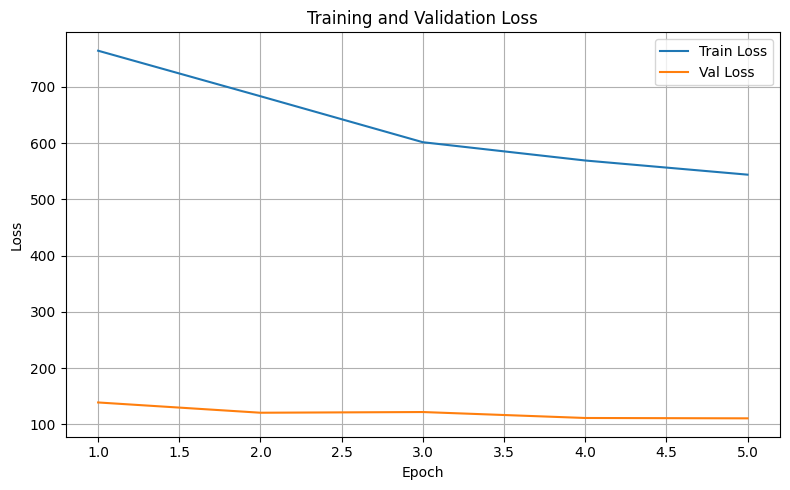

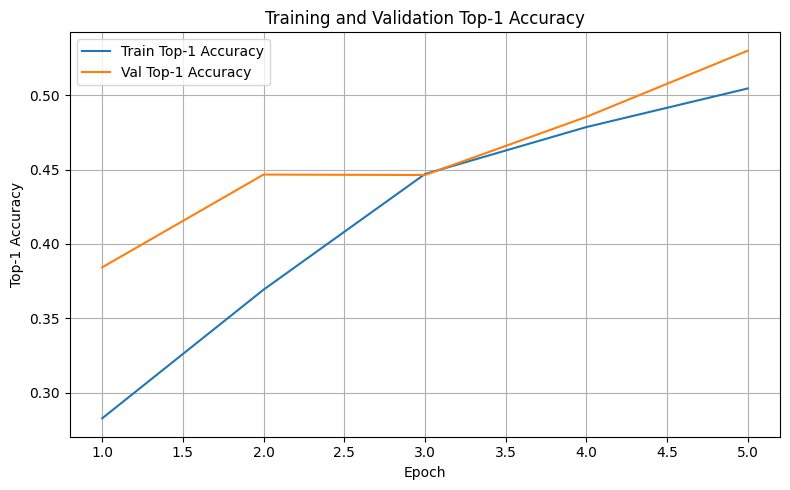

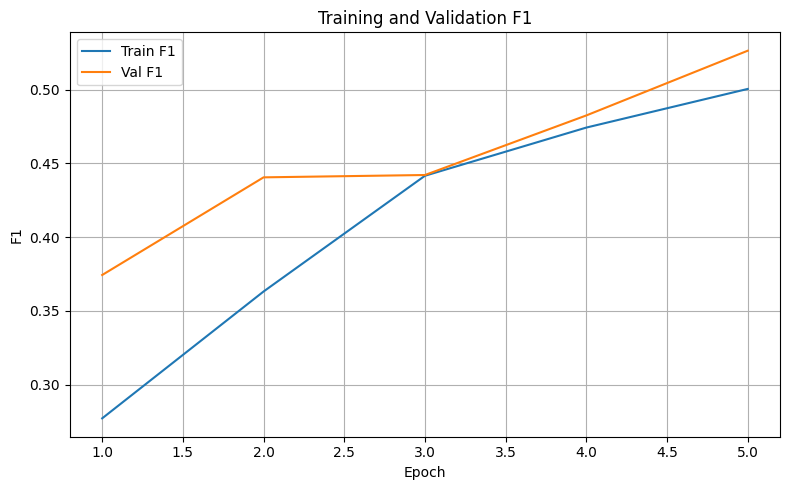

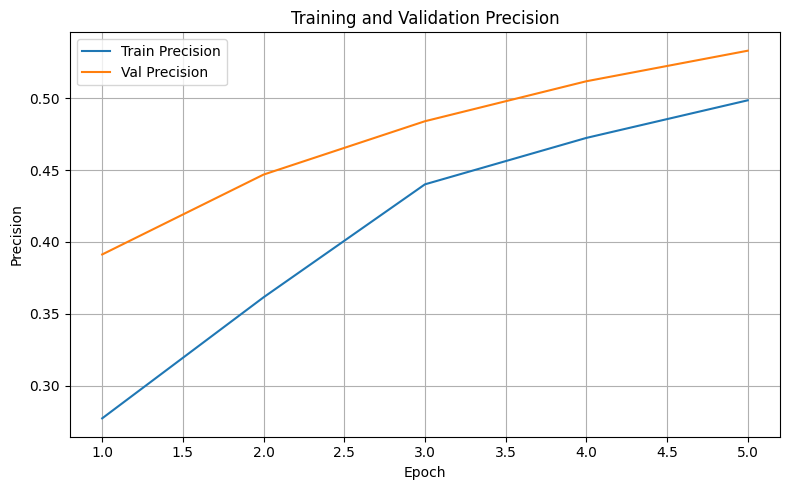

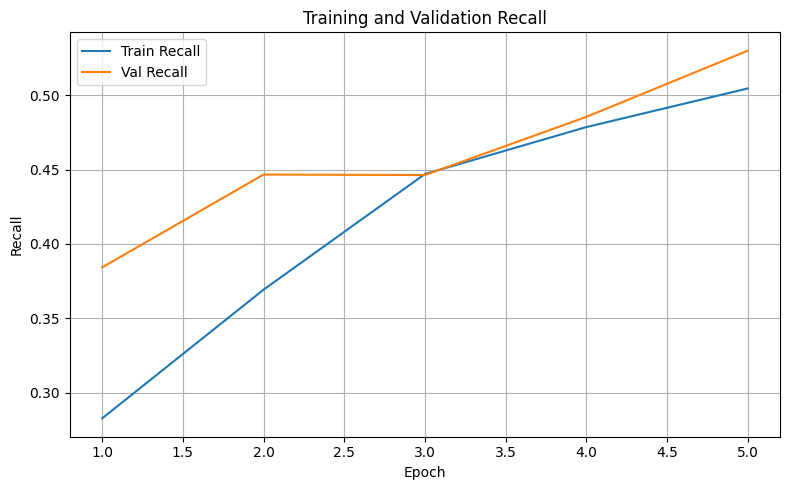

In [8]:
visualizer = Visualizer()
visualizer.plot_metrics(model.trainer, model.run_id)

### Quick prediction preview
We take a few samples from the validation set to check model predictions.

In [9]:
data_iter = iter(val_loader)
images, labels = next(data_iter)
outputs = model.predict(images[:4])

print(f"{'Predicted classes:':<20} {outputs.tolist()}")
print(f"{'Ground truth:':<20} {labels[:4].tolist()}")

Predicted classes:   [3, 1, 1, 1]
Ground truth:        [3, 8, 8, 0]


### Compute and plot confusion matrix
We evaluate the model on the validation loader and visualize the confusion matrix.

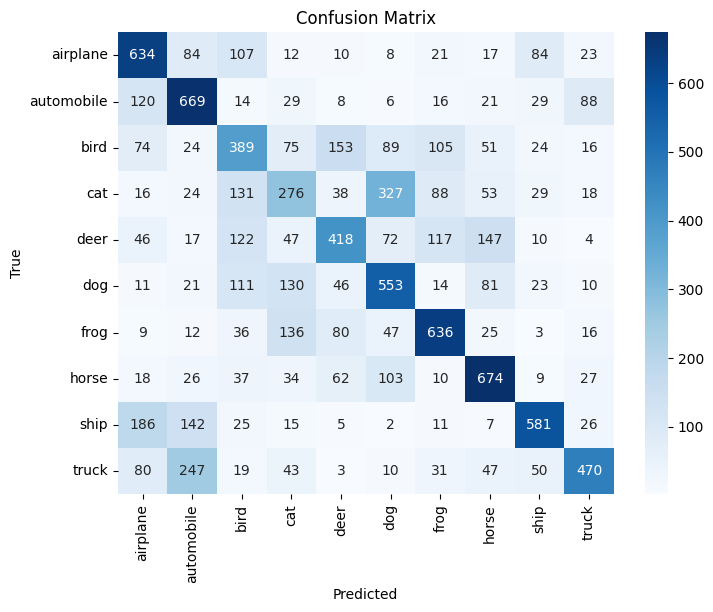

In [ ]:
labels_all, outputs_all = model.predict_on_loader(val_loader)
cm = confusion_matrix_torch(labels_all, outputs_all, num_classes=num_classes)
visualizer.plot_confusion_matrix(cm, train_loader.dataset.classes, model.run_id)

## Step 7 – Save hyperparameters
Finally, we save the training configuration for future reference and reproducibility.

In [11]:
model.save_hyperparams(
    batch_size=batch_size,
    num_epochs=num_epochs,
)

print("Hyperparameters saved successfully.")

Hyperparameters saved to file: experiments/ResNet_Cifar10_2025-10-26_22-25-36\meta.json
Hyperparameters saved successfully.
